### Fetching financial data

In [33]:
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp

assets = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]

data = yf.download(assets, start="2020-01-01", end=date.today())["Close"]

data.to_csv("data/stock_prices.csv")

print(data.head())

[*********************100%***********************]  5 of 5 completed

Ticker           AAPL       AMZN      GOOGL        META        MSFT
Date                                                               
2020-01-02  72.796028  94.900497  68.186813  208.981705  153.630722
2020-01-03  72.088295  93.748497  67.830109  207.875931  151.717697
2020-01-06  72.662704  95.143997  69.638054  211.790985  152.109909
2020-01-07  72.320984  95.343002  69.503548  212.249222  150.722992
2020-01-08  73.484352  94.598503  69.998245  214.401001  153.123749


### Compute portfolio returns and risk

In [34]:
mean_returns = pd.read_csv("data/stock_prices.csv", index_col=0, parse_dates=True)
returns = data.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

mean_returns.to_csv("data/mean_returns.csv")
cov_matrix.to_csv("data/cov_matrix.csv")

### Optimize portfolio

In [35]:
mean_returns = pd.read_csv("data/mean_returns.csv", index_col=0).squeeze()
cov_matrix = pd.read_csv("data/cov_matrix.csv", index_col=0)

n_assets = len(mean_returns)

#define starting weights
w = cp.Variable(n_assets)

#define problem
expected_return = mean_returns.values @ w
portfolio_risk = cp.quad_form(w, cov_matrix.values)

#optimization
objective = cp.Maximize(expected_return - 0.5 * portfolio_risk)
constraints = [cp.sum(w) == 1, w >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

#define optimal weights
optimal_weights = w.value
optimized_portfolio = pd.Series(optimal_weights, index=mean_returns.index)

#save
optimized_portfolio.to_csv("data/optimized_portfolio.csv")

### Risk analysis

In [36]:
returns = pd.read_csv("data/stock_prices.csv", index_col=0, parse_dates=True).pct_change().dropna()

optimized_portfolio = pd.read_csv("data/optimized_portfolio.csv", index_col=0).squeeze()

portfolio_returns = returns @ optimized_portfolio

VaR_95 = np.percentile(portfolio_returns, 5)
CVaR_95 = portfolio_returns[portfolio_returns <= VaR_95].mean()

print(f"VaR 95%: {VaR_95:.4f}")
print(f"CVaR 95%: {CVaR_95:.4f}")

VaR 95%: -0.0310
CVaR 95%: -0.0481


### Efficient frontier

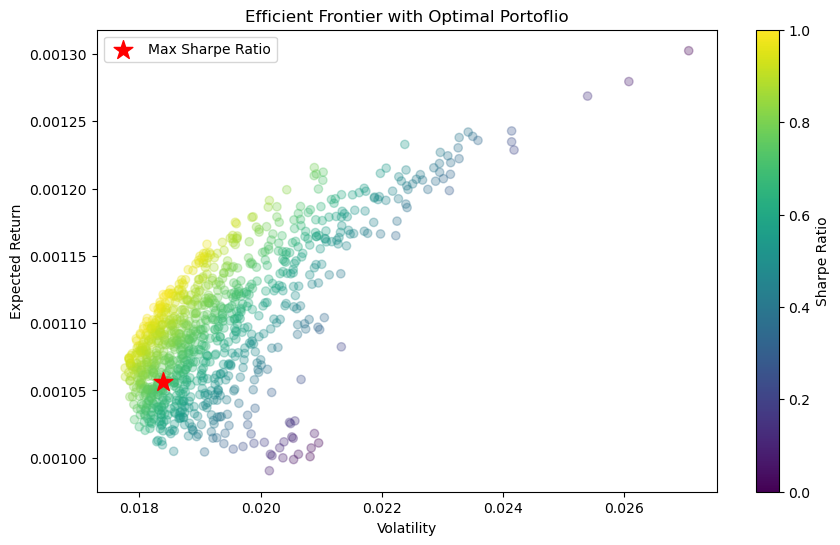

In [38]:
# generate portfolios

n_portfolios = 1000
results = np.zeros((3, n_portfolios))

for i in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(n_assets))
    port_return = np.dot(mean_returns, weights)
    port_volatility = np.sqrt(weights @ cov_matrix @ weights)

#sharpe ratio
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = port_return / port_volatility

#extract optimal portfolios
max_idx = results[2].argmax()
max_return = results[0, max_idc]
max_vol = results[1, max_idx]

#efficient frontier
plt.figure(figsize=(10,6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap="viridis", marker="o", alpha=0.3)
plt.scatter(max_vol, max_return, color="red", marker="*", s=200, label="Max Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.colorbar(label="Sharpe Ratio")
plt.title("Efficient Frontier with Optimal Portoflio")
plt.legend()
plt.show()